In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!touch '/content/drive/MyDrive/Final/Newerdataset.csv'

Mounted at /content/drive


In [ ]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime

from keras import backend as keras_backend
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.layers import Flatten, TimeDistributed, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint , EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def data_normalization(X_train, X_test):
    # Lts do data normalization
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train_norm = (X_train - mean)/std
    X_test_norm = (X_test - mean)/std


    return X_train_norm, X_test_norm

In [ ]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
path = '/content/drive/MyDrive/Final/Newerdataset.csv'
import pandas as pd
# to get the id part of the file
import numpy as np

import os

%matplotlib inline

dataset_dir =  '/content/drive/MyDrive/Final/'

metadata = pd.read_csv('/content/drive/MyDrive/Final/Newerdataset.csv')
metadata.head(10)

def assignNew(label):
  if label == 1 :
    return "snore"
  elif label == 0:
    return "noise"
  elif label == 2:
    return "cough"
  else:
    return -1

metadata["label"] = metadata['class'].apply(assignNew)
metadata.head(10)
metadata.shape

(6000, 3)

In [ ]:
filtered_classes = ['cough','noise','snore']
train_df_filtered = metadata[metadata["label"].isin(filtered_classes)]

print("Number of dataset examples: %d"%(train_df_filtered.shape[0]))
print("Number of Classes: %d"%(train_df_filtered.label.nunique()))
print("\nClasses: ",train_df_filtered.label.unique())

Number of dataset examples: 6000
Number of Classes: 3

Classes:  ['noise' 'cough' 'snore']


In [ ]:
# Pre-processed MFCC coefficients

X = np.load("/content/drive/MyDrive/Final/NX3-mfcc.npy")
y = np.load("/content/drive/MyDrive/Final/Ny3-mfcc.npy")
metadata_path = '/content/drive/MyDrive/Final/Newerdataset.csv'
# Metadata
metadata = pd.read_csv(metadata_path)

In [ ]:
print(X)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
indexes = []
total = len(metadata)
indexes = list(range(0,total))
#randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)
# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]
# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


Test split: 1200 		 Train split: 4800
X test shape: (1200, 40, 445) 	 X train shape: (4800, 40, 445)
y test shape: (1200,) 		 y train shape: (4800,)


In [ ]:
keras_backend.clear_session()

In [ ]:
#1.2 One hot encode labels
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [ ]:
# How data should be structured
num_rows = 40
num_columns = 445
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0],1, num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0],1,num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
#The eventual shape of the features
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
# output (2400, 40, 414, 1) (600, 40, 414, 1)
#       (batch size, height, width,channel)
# Lstm_Train = X_train.reshape
# Lstm_Test = X_test.reshape


(4800, 1, 40, 445, 1) (1200, 1, 40, 445, 1)
(4800,) (1200,)


In [ ]:
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.001
model = Sequential()
model.add(TimeDistributed(Conv2D(64,(3,3),activation=LeakyReLU(alpha=0.1),kernel_regularizer=l2(l2_rate)),input_shape=(1,40,445,1)))
model.add(TimeDistributed(BatchNormalization()))



# model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

#model_mix_shoulder.add(TimeDistributed(Conv2D(128,(3,3),activation='relu')))
#model_mix_shoulder.add(TimeDistributed(Conv2D(56,(3,3),activation='relu')))




model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

# model.add(TimeDistributed(SpatialDropout2D(spatial_dropout_rate_1)))
#model_mix_shoulder.add(TimeDistributed(Conv2D(256,(3,3),activation='relu')))
#model_mix_shoulder.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))


model.add(TimeDistributed(Conv2D(32,(3,3),activation=LeakyReLU(alpha=0.1),kernel_regularizer=l2(l2_rate))))
model.add(BatchNormalization())

model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Flatten()))

#RNN
model.add(LSTM(60,return_sequences=False))


model.add(Dense(3,activation='softmax'))
model.add(Dense(3,activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 38, 443, 64)   640       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 38, 443, 64)   256       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 19, 221, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 17, 219, 32)   18464     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 1, 17, 219, 32)   1

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [ ]:
model_file = 'HybridFinalDon.h5' #content/models/Hybrid-train.hdf5
models_path = os.path.abspath('/content/drive/MyDrive/Final')
model_path = os.path.join(models_path, model_file)
# Save checkpoints

mc = ModelCheckpoint(filepath=model_path, monitor='val_acc', mode='max', verbose=1)
model_history = model.fit(X_train, y_train_encoded, validation_split=1/12, batch_size=128, verbose = 1,shuffle=True, epochs=110, callbacks=[mc])


Epoch 1/110
35/35 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.6282
Epoch 1: saving model to /content/drive/MyDrive/Final/HybridFinalDon.h5
35/35 [==============================] - 19s 255ms/step - loss: 0.9188 - accuracy: 0.6282 - val_loss: 0.8758 - val_accuracy: 0.6600
Epoch 2/110
34/35 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.6540
Epoch 2: saving model to /content/drive/MyDrive/Final/HybridFinalDon.h5
35/35 [==============================] - 5s 131ms/step - loss: 0.8767 - accuracy: 0.6548 - val_loss: 0.8584 - val_accuracy: 0.6700
Epoch 3/110
35/35 [==============================] - ETA: 0s - loss: 0.8672 - accuracy: 0.6582
Epoch 3: saving model to /content/drive/MyDrive/Final/HybridFinalDon.h5
35/35 [==============================] - 5s 130ms/step - loss: 0.8672 - accuracy: 0.6582 - val_loss: 0.8506 - val_accuracy: 0.6725
Epoch 4/110
35/35 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6602
Epoch 4: s

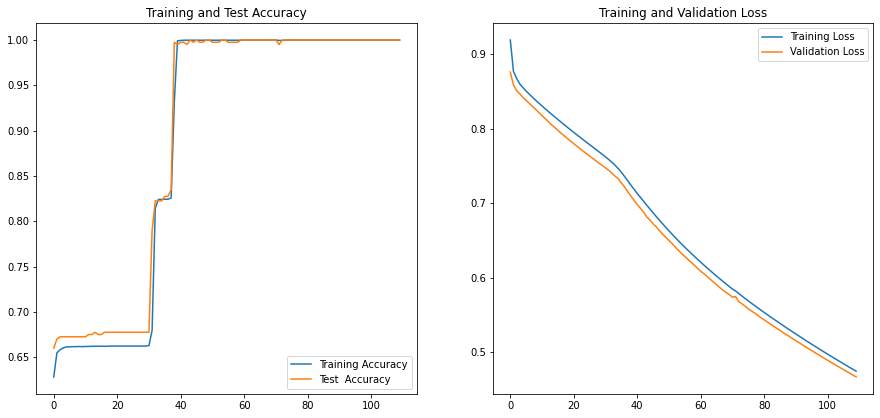

8/8 [==============================] - 1s 52ms/step - loss: 0.4753 - accuracy: 0.9975
Generate a prediction
1/1 [==============================] - 0s 483ms/step
prediction shape: (1, 3)
[2]


In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(110)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test  Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.evaluate(X_test,y_test_encoded,batch_size=150)
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(X_test[:1])

classes_x=np.argmax(prediction,axis=1)
print("prediction shape:", prediction.shape)
print(classes_x)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.4726      100.0000
Test:             0.4753       99.7500
Normal diff          0.57 


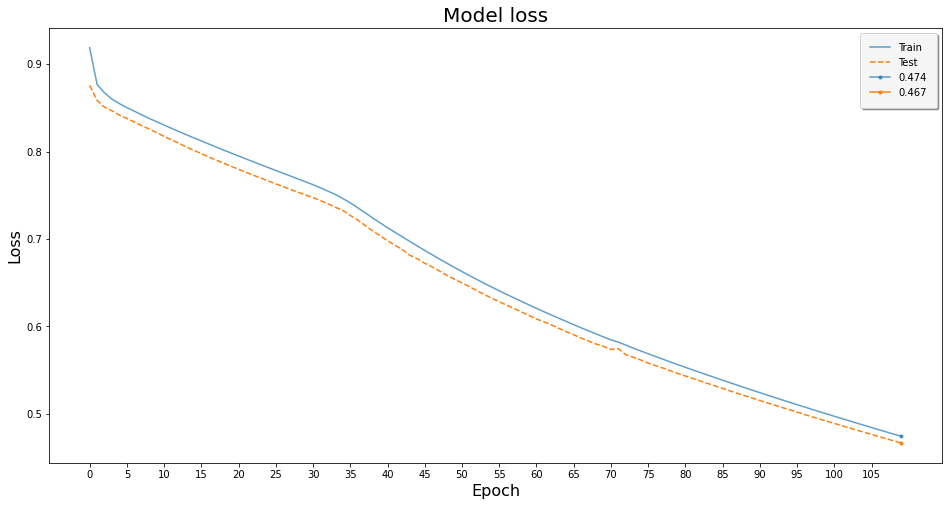

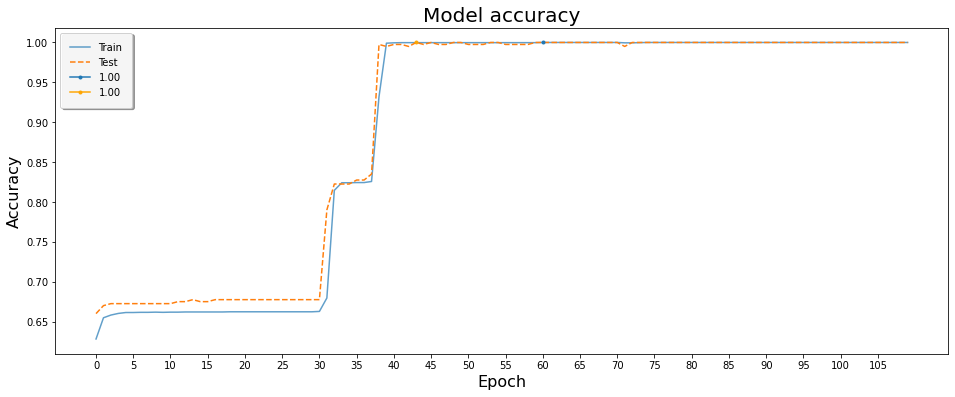

Generate a prediction
1/1 [==============================] - 0s 365ms/step
prediction shape: (1, 3)
[2]


In [ ]:
from keras.models import Sequential, load_model


def evaluate_model(model, X_train, y_train, X_test, y_test):
  train_score = model.evaluate(X_train, y_train, verbose=0)
  test_score = model.evaluate(X_test, y_test, verbose=0)
  return train_score, test_score

def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
  dash = '-' * 38

# Compute scores
  train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)

# Pint Train vs Test report
  print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
  print(dash)
  print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
  print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))


# Calculate and report normalized error difference?
  if (calc_normal):
    max_err = max(train_score[0], test_score[0])
    error_diff = max_err - min(train_score[0], test_score[0])
    normal_diff = error_diff * 100 / max_err
    print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))
"""
    Plotting
"""

def plot_train_history(history, x_ticks_vertical=False):
  history = history.history

# min loss / max accs
  min_loss = min(history['loss'])
  min_val_loss = min(history['val_loss'])
  max_accuracy = max(history['accuracy'])
  max_val_accuracy = max(history['val_accuracy'])
# x pos for loss / acc min/max
  min_loss_x = history['loss'].index(min_loss)
  min_val_loss_x = history['val_loss'].index(min_val_loss)
  max_accuracy_x = history['accuracy'].index(max_accuracy)
  max_val_accuracy_x = history['val_accuracy'].index(max_val_accuracy)

# summarize history for loss, display min
  plt.figure(figsize=(16,8))
  plt.plot(history['loss'], color="#1f77b4", alpha=0.7)
  plt.plot(history['val_loss'], color="#ff7f0e", linestyle="--")
  plt.plot(min_loss_x, min_loss, marker='o', markersize=3, color="#1f77b4", alpha=0.7, label='Inline label')
  plt.plot(min_val_loss_x, min_val_loss, marker='o', markersize=3, color="#ff7f0e", alpha=7, label='Inline label')
  plt.title('Model loss', fontsize=20)
  plt.ylabel('Loss', fontsize=16)
  plt.xlabel('Epoch', fontsize=16)
  plt.legend(['Train',
              'Test',
            ('%.3f' % min_loss),
           ('%.3f' % min_val_loss)], loc='upper right',
            fancybox=True,
            framealpha=0.9,
            shadow=True, borderpad=1)

  if (x_ticks_vertical):
     plt.xticks(np.arange(0, len(history['loss']), 5.0), rotation='vertical')
  else:
    plt.xticks(np.arange(0, len(history['loss']), 5.0))

  plt.show()

    # summarize history for accuracy, display max
  plt.figure(figsize=(16,6))
  plt.plot(history['accuracy'], alpha=0.7)
  plt.plot(history['val_accuracy'], linestyle="--")
  plt.plot(max_accuracy_x, max_accuracy, marker='o', markersize=3, color="#1f77b4", alpha=7)
  plt.plot(max_val_accuracy_x, max_val_accuracy, marker='o', markersize=3, color="orange", alpha=7)
  plt.title('Model accuracy', fontsize=20)
  plt.ylabel('Accuracy', fontsize=16)
  plt.xlabel('Epoch', fontsize=16)
  plt.legend(['Train',
             'Test',
           ('%.2f' % max_accuracy),
           ('%.2f' % max_val_accuracy)],
            loc='upper left', fancybox=True, framealpha=0.9, shadow=True,borderpad=1)
  plt.figure(num=1, figsize=(10, 6))

  if (x_ticks_vertical):
      plt.xticks(np.arange(0, len(history['accuracy']), 5.0), rotation='vertical')
  else:
      plt.xticks(np.arange(0, len(history['accuracy']), 5.0))

  plt.show()
# Load best saved model
model = load_model('/content/drive/MyDrive/Final/HybridFinalDon.h5')
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)
plot_train_history(model_history)

# Generate a prediction using model.predict()
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(X_test[:1])

classes_x=np.argmax(prediction,axis=1)
print("prediction shape:", prediction.shape)
print(classes_x)

In [ ]:
def compute_confusion_matrix(y_true,
               y_pred,
               classes,
               normalize=False):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm


# Plots a confussion matrix
def plot_confusion_matrix(cm,
                          classes,
                          normalized=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

<ipython-input-19-a144b6753bc6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['pred'] = yhat_probs


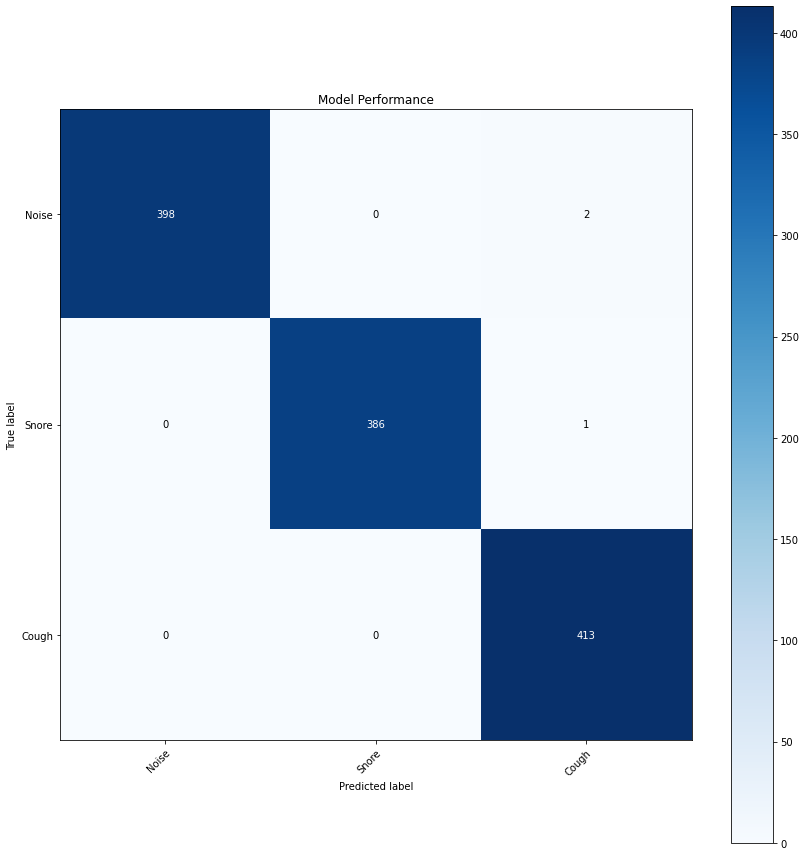

In [ ]:

labels = ['Noise', 'Snore', 'Cough']

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

plot_confusion_matrix(cm,
                      labels,
                      normalized=False,
                      title="Model Performance",
                      cmap=plt.cm.Blues,
                      size=(12,12))
